# Final Project
## Members
#### - Michael Conner
#### - Jackson Rolando
#### - Ryan Kruk
## Dataset
#### - Space Titanic - https://www.kaggle.com/competitions/spaceship-titanic/data
## Research Question
#### - Predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly using a set of personal records recovered from the ship's damaged computer system.
## Hypothesis

In [1]:
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy.stats as stats

2023-02-10 09:33:28.797868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 09:33:28.935487: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 09:33:28.938284: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-10 09:33:28.938299: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
df = pd.read_csv('./train.csv')
df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


- We could either bucket the ages or have them put as continuous
- We could have another variable for stuff like "used_room_service", "used_food_court", or bucket those columns as well

### Data Preprocessing

In [3]:
train = df.copy()
print(df['CryoSleep'].value_counts())

False    5439
True     3037
Name: CryoSleep, dtype: int64


Split Passenger ID into the group and number within that group.

In [4]:
passenger_ids = train.PassengerId
group, num = zip(*[pid.split('_') for pid in passenger_ids])
train['PassengerId_Group'] = group
train['PassengerId_Num'] = num

Split Cabin into the deck, number, and side.

In [5]:
cabins = train.Cabin
deck, num, side = zip(*[cabin.split('/') if type(cabin) != float else (cabin, cabin, cabin) for cabin in cabins])
train['Cabin_Deck'] = deck
train['Cabin_Num'] = num
train['Cabin_Side'] = side

Split Name into first and last name.

In [6]:
names = train.Name
first, last = zip(*[name.split(' ') if type(name) != float else (name, name) for name in names])
train['FirstName'] = first
train['LastName'] = last

In [7]:
categorical_columns = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Num', 'Cabin_Side']

In [8]:
train['HomePlanet'] = train['HomePlanet'].fillna('Unknown')
train['CryoSleep'] = train['CryoSleep'].fillna(False)
train['Destination'] = train['Destination'].fillna('TRAPPIST-1e')
train['VIP'] = train['VIP'].fillna(False)

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

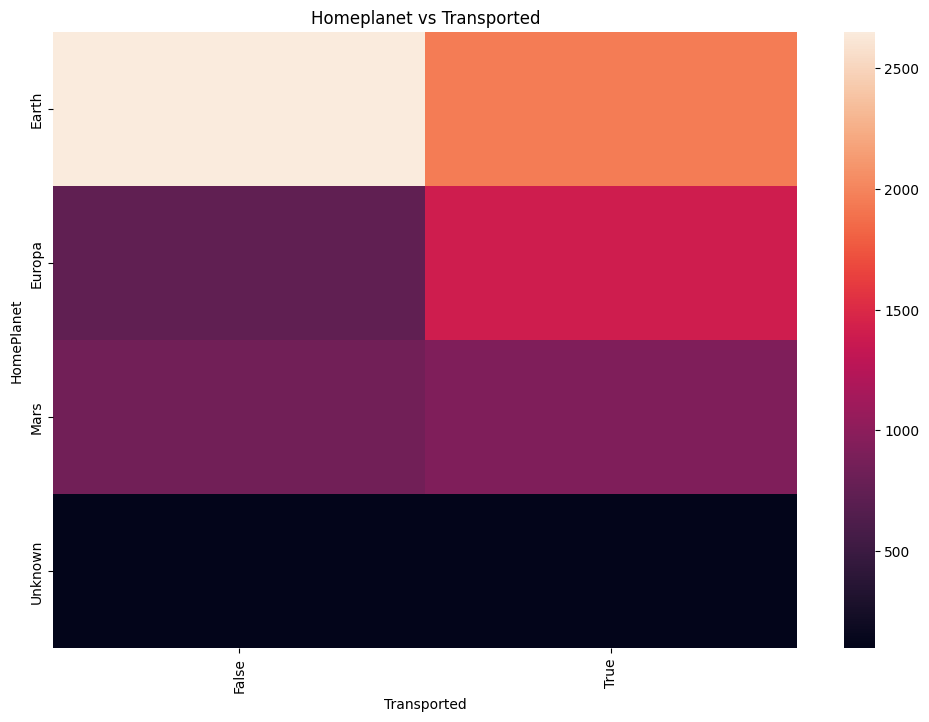

HomePlanet
Earth      4602
Europa     2131
Mars       1759
Unknown     201
dtype: int64


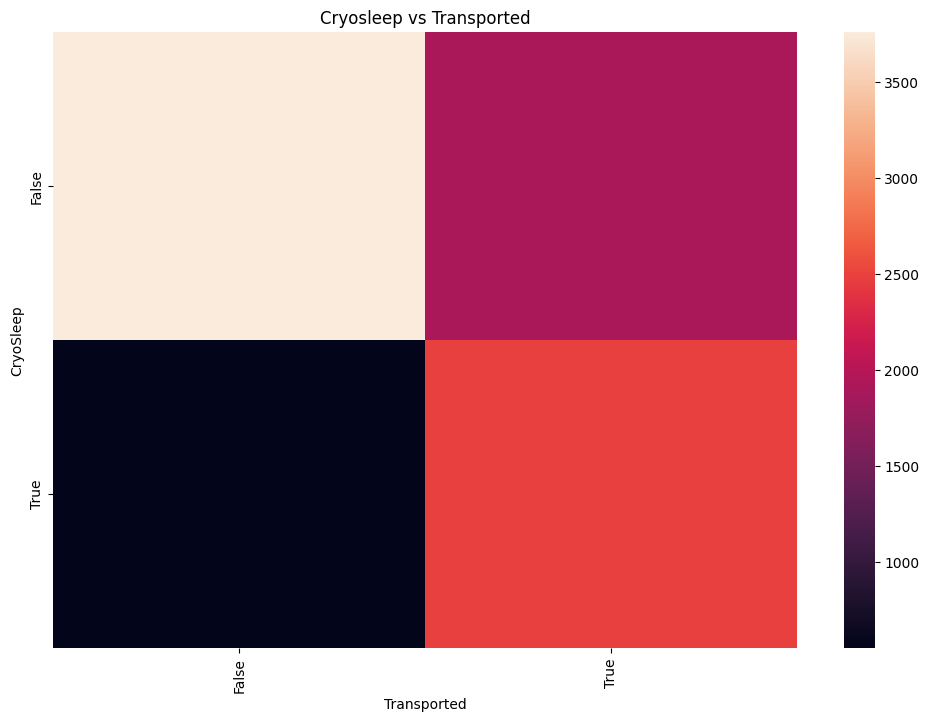

CryoSleep
False    5656
True     3037
dtype: int64


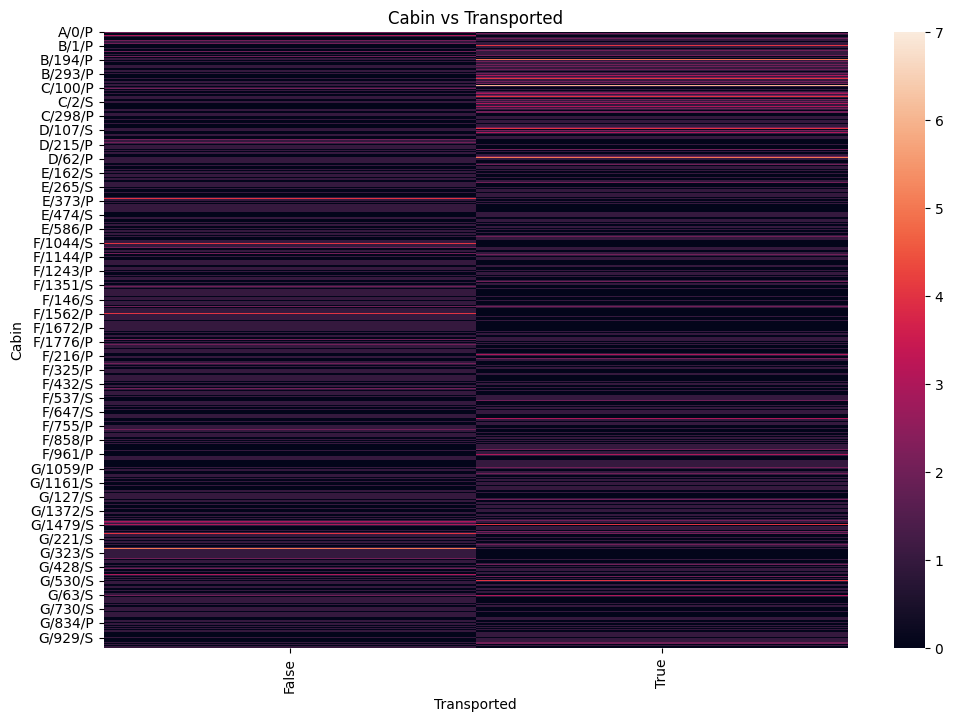

Cabin
G/734/S     8
C/21/P      7
G/1368/P    7
B/82/S      7
G/981/S     7
           ..
F/1245/P    1
F/1244/S    1
F/1243/S    1
F/1243/P    1
T/3/P       1
Length: 6560, dtype: int64


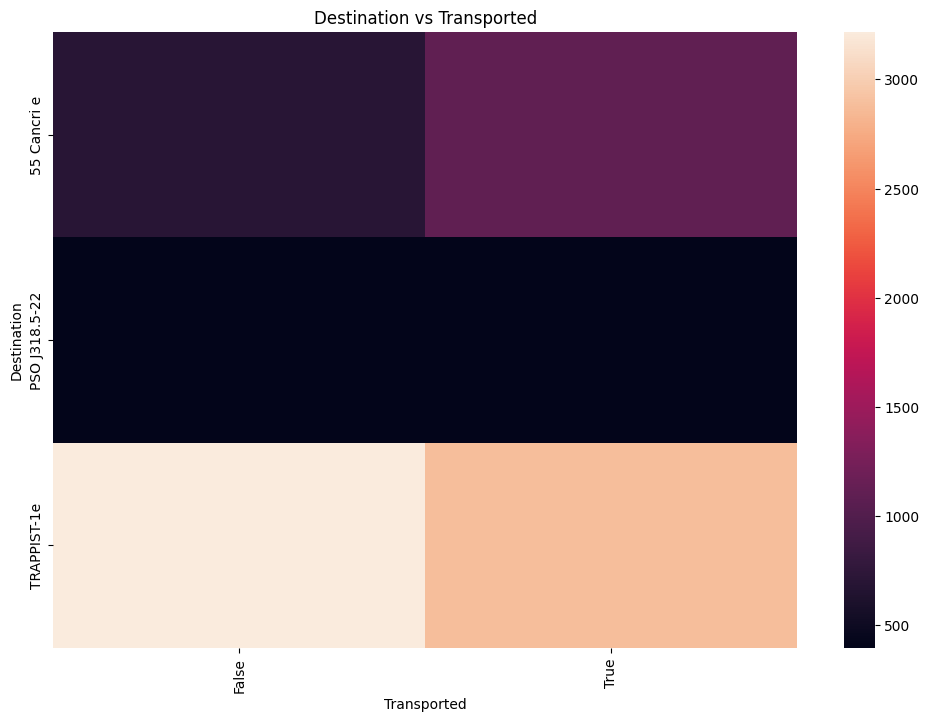

Destination
TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
dtype: int64


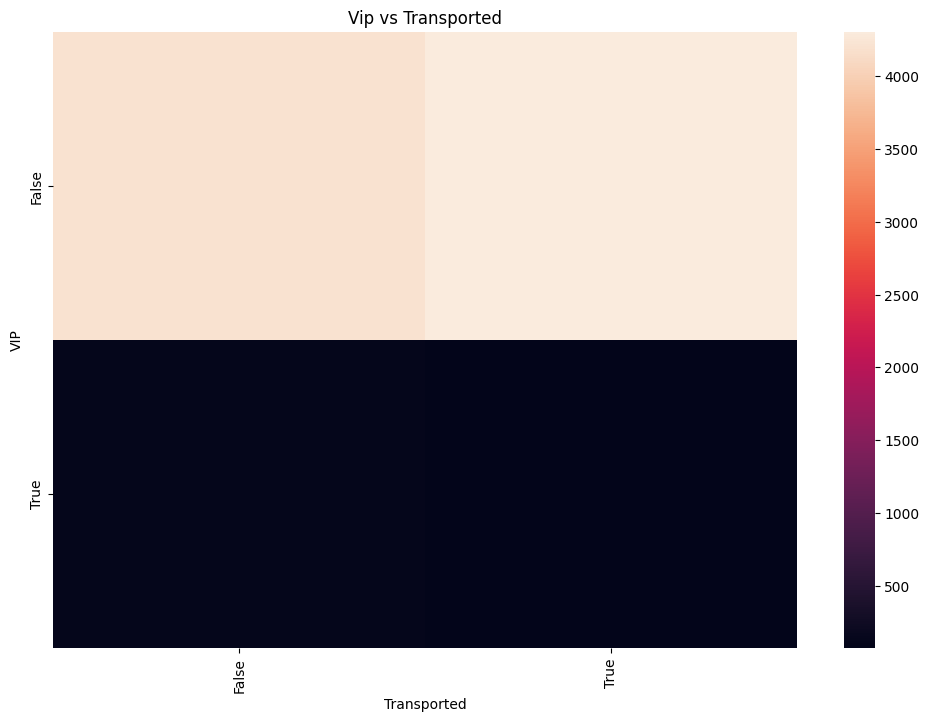

VIP
False    8494
True      199
dtype: int64


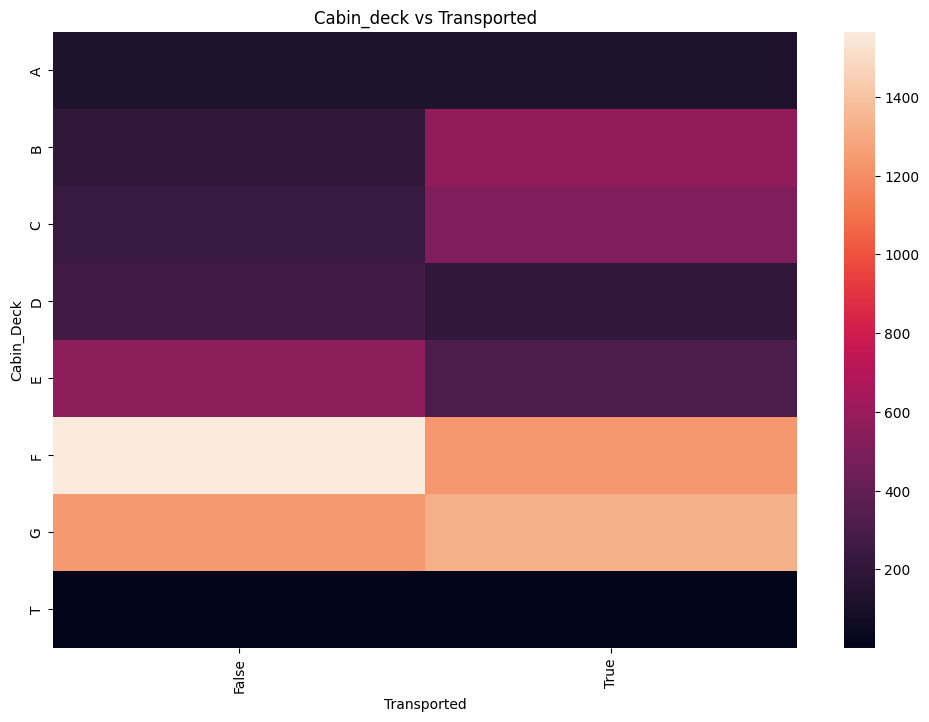

Cabin_Deck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
dtype: int64


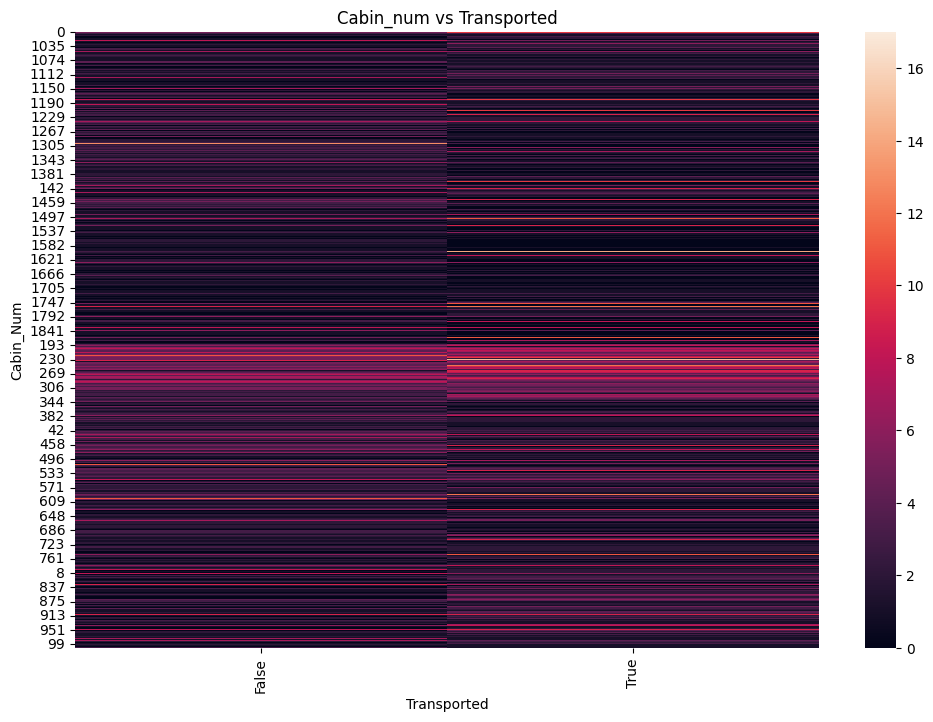

Cabin_Num
82      28
86      22
19      22
176     21
97      21
        ..
1685     1
639      1
1082     1
1689     1
1877     1
Length: 1817, dtype: int64


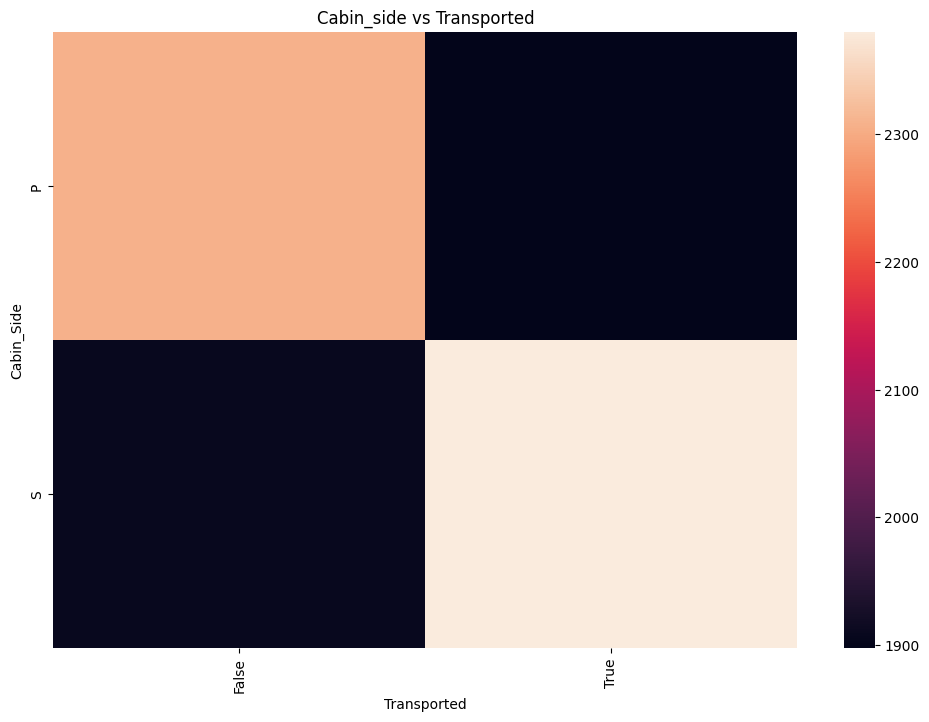

Cabin_Side
S    4288
P    4206
dtype: int64


In [10]:
for col in categorical_columns:
    plt.figure(figsize=(12, 8))
    ax = sns.heatmap(train.value_counts(subset=["Transported", col]).unstack(level=0).fillna(0))
    ax.set_title(col.capitalize() + " vs Transported")
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    plt.show()
    print(train.value_counts(col))

Most of the categorical features seem like they could be used to predict whether or not passengers were transported, as the distributions of people being transported vs not being transported are different accross categories. VIP status, on the other hand, seems like it doesn't split the data well, so It will probably not be very important to the final model.

Here we'll run chi-squared tests for each of the variables against whether or not the passengers were transported:

In [11]:
for col in categorical_columns:
    combination_counts = train[["Transported", col]].groupby(by=["Transported", col]).size().unstack(level=0, fill_value=0)
    chi2, p, _, _ = stats.chi2_contingency(combination_counts)
    print(col + " - chi2: " + str(chi2) + ", p: " + str(p))

HomePlanet - chi2: 324.96723663979583, p: 3.9214919240932375e-70
CryoSleep - chi2: 1838.5677340571679, p: 0.0
Cabin - chi2: 6849.936214884505, p: 0.006047486175170891
Destination - chi2: 105.56297434781096, p: 1.1947894351445014e-23
VIP - chi2: 11.575951627085105, p: 0.0006681023600149099
Cabin_Deck - chi2: 392.2880411997481, p: 1.0743307258871414e-80
Cabin_Num - chi2: 1996.3773737464164, p: 0.0018055974346714817
Cabin_Side - chi2: 91.0595970786772, p: 1.3940936254458288e-21


The distribution of transported vs not transported seems to vary significantly across all of the columns, including VIP status. Cabin has the highest p-value, and even its distributions qualify as statistically significant with respect to a p-value of 0.01. When the cabin was split into its containing pieces though, each of them performed better than just the cabin itself. Cabin deck has the lowest p-value, meaning the distributions of transported vs not transported differed across cabin decks. This, along with most of the other columns, seem like they could prove great for prediction. 